# Task 4: Insights & Recommendations

Derive bank-specific insights from sentiment and themes, produce visualizations, and recommend product improvements.

This notebook uses the project's helpers (`EDA`, `CustomerFeedbackPipeline`, `Plotter`) and writes plots to `outputs/figures`.


In [4]:
# Environment & helpers
import sys
from pathlib import Path

repo_root = Path('..').resolve()
sys.path.insert(0, str(repo_root))

import pandas as pd

# Project helper imports
from src.customer_analytics.analysis.eda import EDA
from src.customer_analytics.pipeline.customer_feedback_pipeline import CustomerFeedbackPipeline
from src.customer_analytics.visualisation.plotter import Plotter

# Ensure output directories exist
OUT_FIG_DIR = repo_root / 'outputs' / 'figures'
OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_REP_DIR = repo_root / 'outputs' / 'reports'
OUT_REP_DIR.mkdir(parents=True, exist_ok=True)

print('Figures ->', OUT_FIG_DIR)


Figures -> C:\BackUp\web-projects\tenx\customer-fintech-week2\outputs\figures


In [5]:
# Data loading: prefer the outputs/models CSV produced by Task 2
def find_processed_csv():
    repo_root = Path('..').resolve()
    candidates = [
        repo_root / 'outputs' / 'models' / 'reviews_with_sentiment_and_themes.csv',
        repo_root / 'data' / 'processed' / 'reviews_processed.csv',
    ]
    for p in candidates:
        if p and p.exists():
            return p.resolve()
    return None

csv_path = find_processed_csv()
if not csv_path:
    raise FileNotFoundError('Processed CSV not found. Run Task 1/2 to produce outputs/models/reviews_with_sentiment_and_themes.csv')

print('Loading:', csv_path)
df = pd.read_csv(csv_path)
print('Rows loaded:', len(df))
df.head()


Loading: C:\BackUp\web-projects\tenx\customer-fintech-week2\outputs\models\reviews_with_sentiment_and_themes.csv
Rows loaded: 1200


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_score,sentiment_label,identified_theme
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play,0.0000,neutral,"good, application, service, work, job"
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play,0.4927,positive,"good, application, service, work, job"
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play,0.0000,neutral,"good, application, service, work, job"
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play,0.4926,positive,"good, application, service, work, job"
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play,0.4404,positive,"good, application, service, work, job"


## Analysis & Visualization

Run the EDA and plotting helpers below to summarise dataset statistics, rating distributions, sentiment trends, and common themes per bank.


Basic dataset stats:
{'total_reviews': 1200, 'columns': ['review_id', 'review_text', 'rating', 'review_date', 'review_year', 'review_month', 'bank_code', 'bank_name', 'user_name', 'thumbs_up', 'text_length', 'source', 'sentiment_score', 'sentiment_label', 'identified_theme'], 'missing_values': {'review_id': 0, 'review_text': 0, 'rating': 0, 'review_date': 0, 'review_year': 0, 'review_month': 0, 'bank_code': 0, 'bank_name': 0, 'user_name': 0, 'thumbs_up': 0, 'text_length': 0, 'source': 0, 'sentiment_score': 0, 'sentiment_label': 0, 'identified_theme': 0}, 'data_types': {'review_id': dtype('O'), 'review_text': dtype('O'), 'rating': dtype('int64'), 'review_date': dtype('O'), 'review_year': dtype('int64'), 'review_month': dtype('int64'), 'bank_code': dtype('O'), 'bank_name': dtype('O'), 'user_name': dtype('O'), 'thumbs_up': dtype('int64'), 'text_length': dtype('int64'), 'source': dtype('O'), 'sentiment_score': dtype('float64'), 'sentiment_label': dtype('O'), 'identified_theme': dtype('O')}

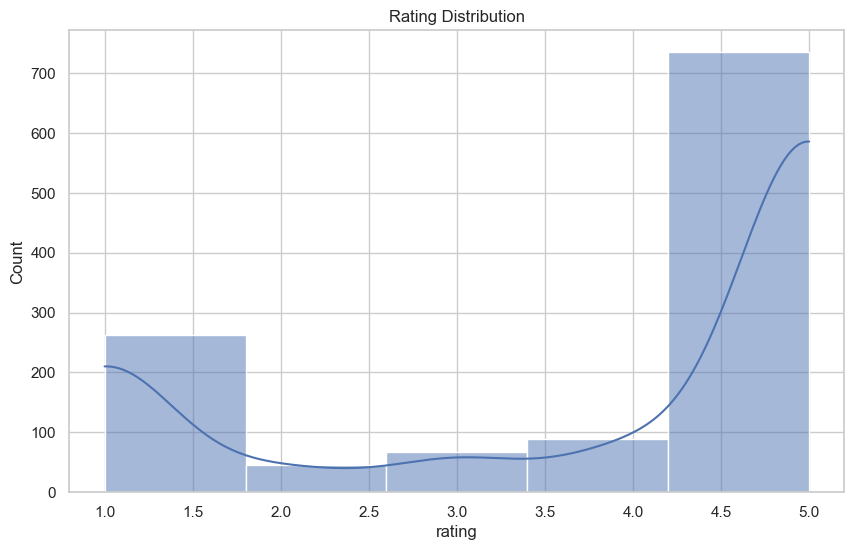

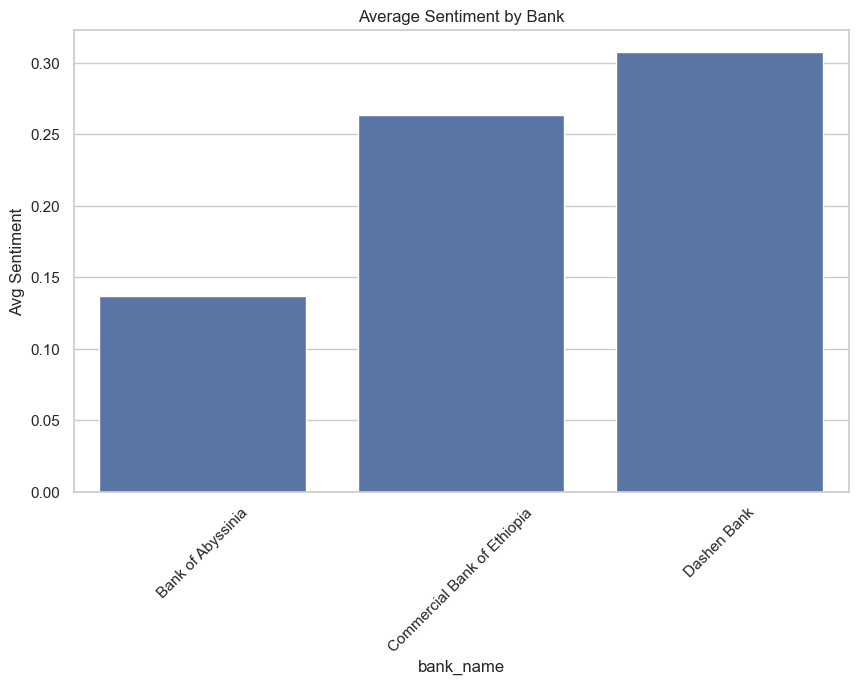

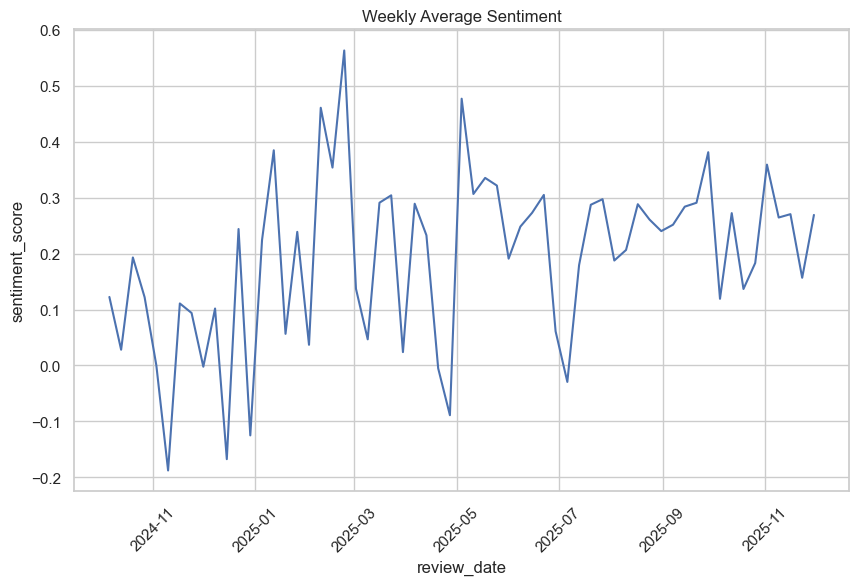


-- Bank of Abyssinia top words --
{'app': 149, 'good': 62, 'not': 47, 'bank': 45, 'very': 34, 'please': 31, 'best': 31, 'boa': 29, 'work': 25, 'banking': 24}

-- Commercial Bank of Ethiopia top words --
{'app': 112, 'good': 87, 'not': 46, 'very': 36, 'bank': 29, 'best': 28, 'cbe': 27, 'nice': 25, 'update': 17, 'application': 16}

-- Dashen Bank top words --
{'app': 183, 'good': 61, 'bank': 57, 'dashen': 44, 'banking': 38, 'best': 38, 'very': 37, 'not': 34, 'super': 33, 'one': 29}


In [6]:
# Prepare EDA and Plotter instances
eda = EDA(df)

print('Basic dataset stats:')
print(eda.get_basic_stats())

plotter = Plotter()

# 1) Rating distribution
if 'rating' in df.columns:
    plotter.plot_histogram(df, 'rating', title='Rating Distribution', bins=5)

# 2) Average sentiment by bank (bar)
if 'sentiment_score' in df.columns and 'bank_name' in df.columns:
    avg_sent = df.groupby('bank_name')['sentiment_score'].mean().reset_index()
    plotter.plot_bar(avg_sent, x='bank_name', y='sentiment_score', title='Average Sentiment by Bank', ylabel='Avg Sentiment')

# 3) Weekly average sentiment time series
if 'review_date' in df.columns and 'sentiment_score' in df.columns:
    ts_df = df.copy()
    ts_df['review_date'] = pd.to_datetime(ts_df['review_date'])
    weekly = ts_df.set_index('review_date').resample('W')['sentiment_score'].mean().reset_index()
    plotter.plot_time_series(weekly, 'review_date', 'sentiment_score', title='Weekly Average Sentiment')

# 4) Top words per bank using EDA.get_top_words
bank_insights = {}
for bank in df['bank_name'].dropna().unique():
    subset = df[df['bank_name'] == bank]
    eda_bank = EDA(subset)
    top_words = eda_bank.get_top_words(column='review_text', n=10)
    bank_insights[bank] = top_words
    print(f'\n-- {bank} top words --')
    print(top_words)


# Final Insights & Recommendations

**Key Performance Indicators (KPI) check**:

- **Total reviews**: 1200
- **Banks covered**: Bank of Abyssinia, Commercial Bank of Ethiopia, Dashen Bank
- **Sentiment scores available**: True
- **Thematic labels available**: True
- **AHT (Average Handling Time)**: MISSING — KPI unmet (no `AHT` column).

## Visualizations

- **sentiment_trends**: `outputs\figures\sentiment_trends.png`
- **rating_distribution**: `outputs\figures\rating_distribution.png`
- **Bank of Abyssinia_positive_keywords**: `outputs\figures\wordcloud_Bank of Abyssinia_positive.png`
- **Bank of Abyssinia_negative_keywords**: `outputs\figures\wordcloud_Bank of Abyssinia_negative.png`
- **Commercial Bank of Ethiopia_positive_keywords**: `outputs\figures\wordcloud_Commercial Bank of Ethiopia_positive.png`
- **Commercial Bank of Ethiopia_negative_keywords**: `outputs\figures\wordcloud_Commercial Bank of Ethiopia_negative.png`
- **Dashen Bank_positive_keywords**: `outputs\figures\wordcloud_Dashen Bank_positive.png`
- **Dashen Bank_negative_keywords**: `outputs\figures\wordcloud_Dashen Bank_negative.png`

## Bank-level Insights and Recommendations

### Bank of Abyssinia

- **Top drivers**: good, app, the, and, this, best, please, bank.
- **Top pain points**: the, app, and, this, worst, but, you, bank.

- **Recommendation**: Perform targeted UX testing to validate flows users report as confusing.
- **Recommendation**: Improve monitoring and release rollback procedures.

### Commercial Bank of Ethiopia

- **Top drivers**: good, app, the, and, very, best, nice, this.
- **Top pain points**: the, and, app, not, this, why, cbe, what.

- **Recommendation**: Perform targeted UX testing to validate flows users report as confusing.
- **Recommendation**: Improve monitoring and release rollback procedures.

### Dashen Bank

- **Top drivers**: app, the, and, good, best, bank, dashen, this.
- **Top pain points**: the, app, and, not, worst, this, bank, ever.

- **Recommendation**: Perform targeted UX testing to validate flows users report as confusing.
- **Recommendation**: Improve monitoring and release rollback procedures.

## Cross-bank comparison

- Compare banks by mean sentiment and rating distributions (see visualizations).
- Look for differences in common pain points (e.g., one bank may show more connection/OTP problems while another shows crashes).

## Ethics & Bias

- Reviews are self-selected and may over-represent frustrated or highly satisfied users (selection bias).
- Language differences and automated translation can distort sentiment scores.
- Consider demographic and channel biases (Google Play users differ from in-branch customers).

---

Generated with `scripts/generate_insights.py`

## Generated Figures

The following cell will display all PNG charts produced by `scripts/generate_insights.py` from `outputs/figures/`.

### rating_distribution.png

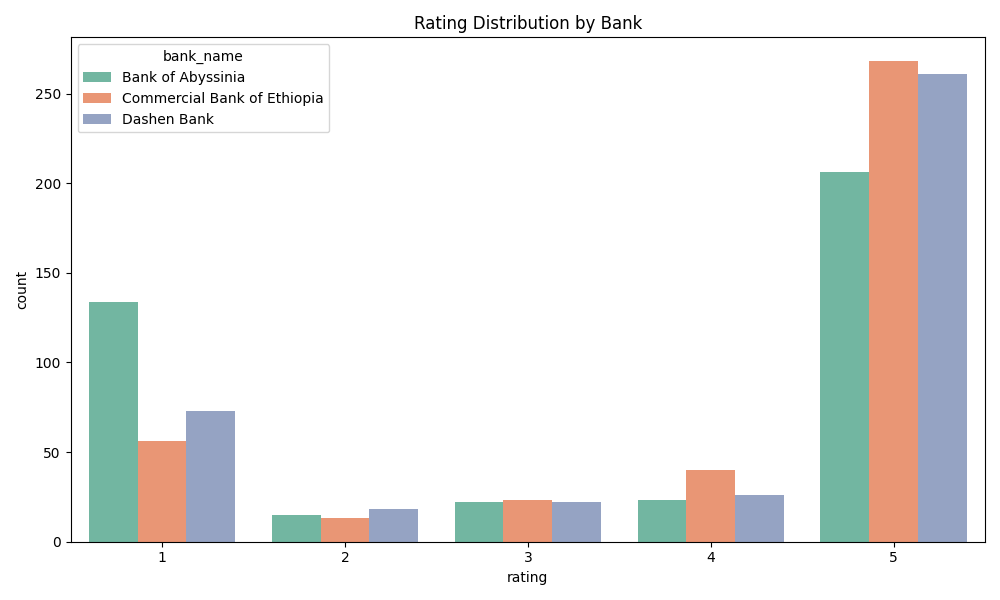

### sentiment_trends.png

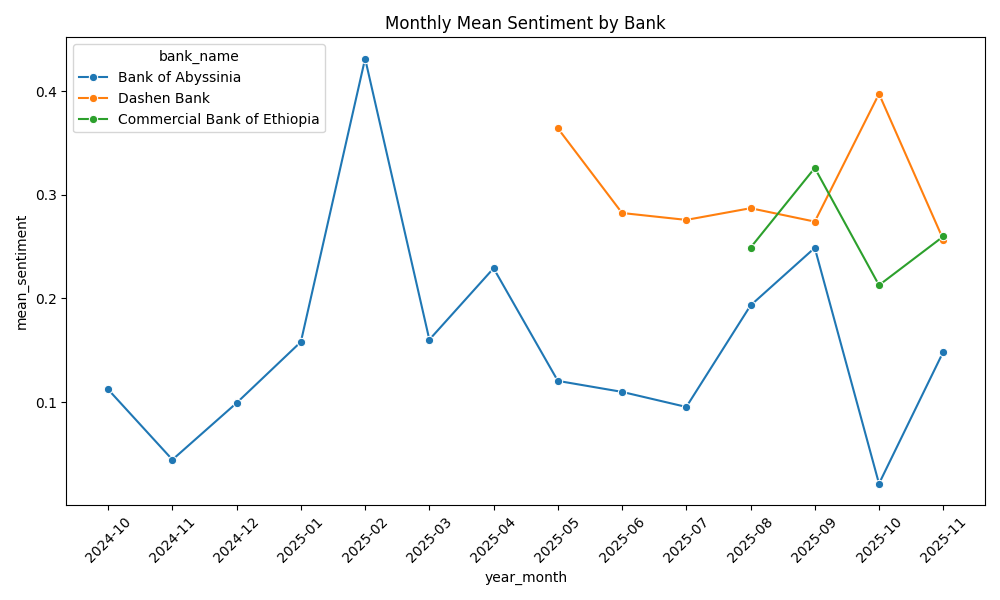

### wordcloud_Bank of Abyssinia_negative.png

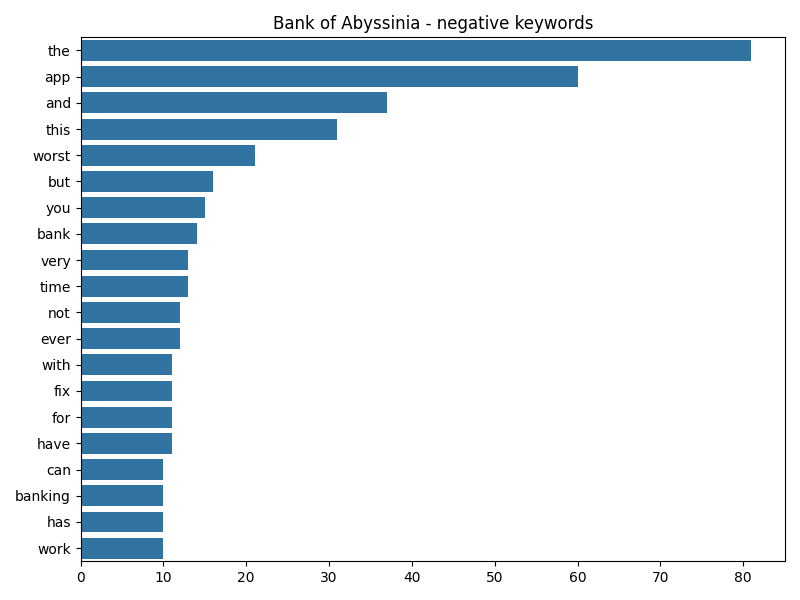

### wordcloud_Bank of Abyssinia_positive.png

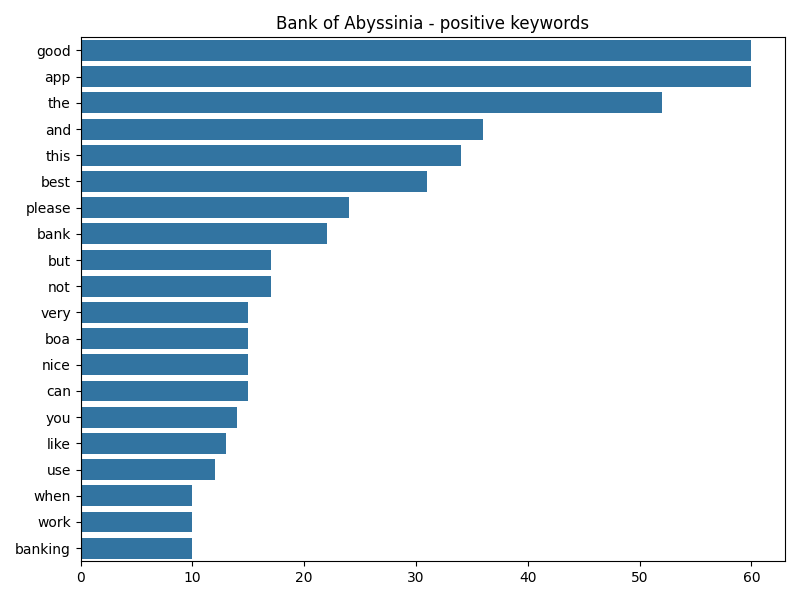

### wordcloud_Commercial Bank of Ethiopia_negative.png

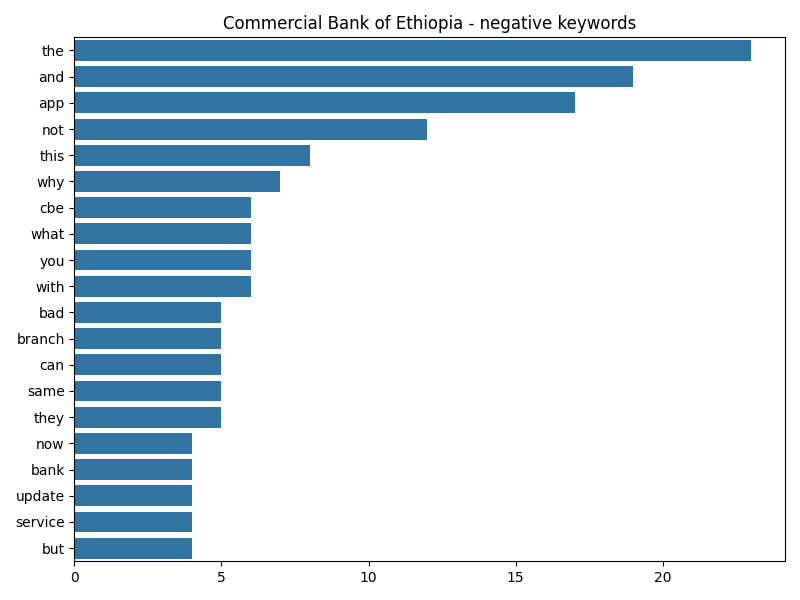

### wordcloud_Commercial Bank of Ethiopia_positive.png

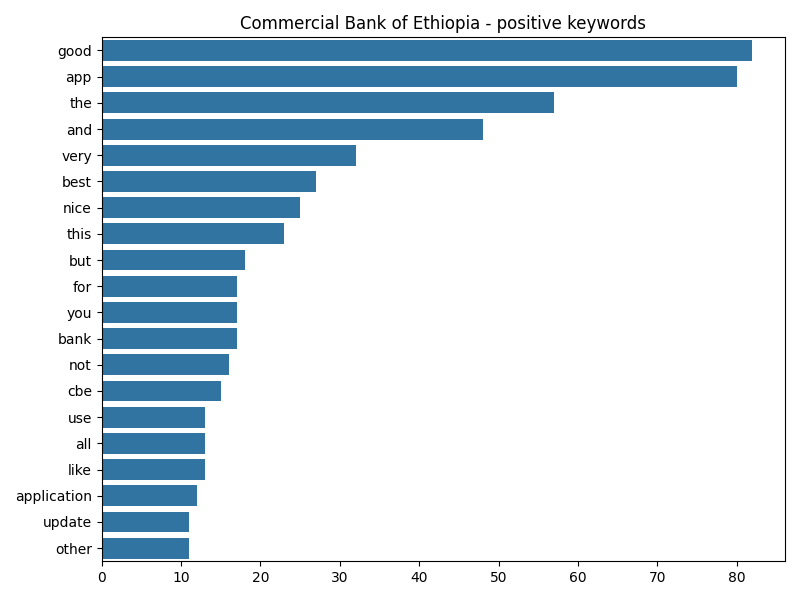

### wordcloud_Dashen Bank_negative.png

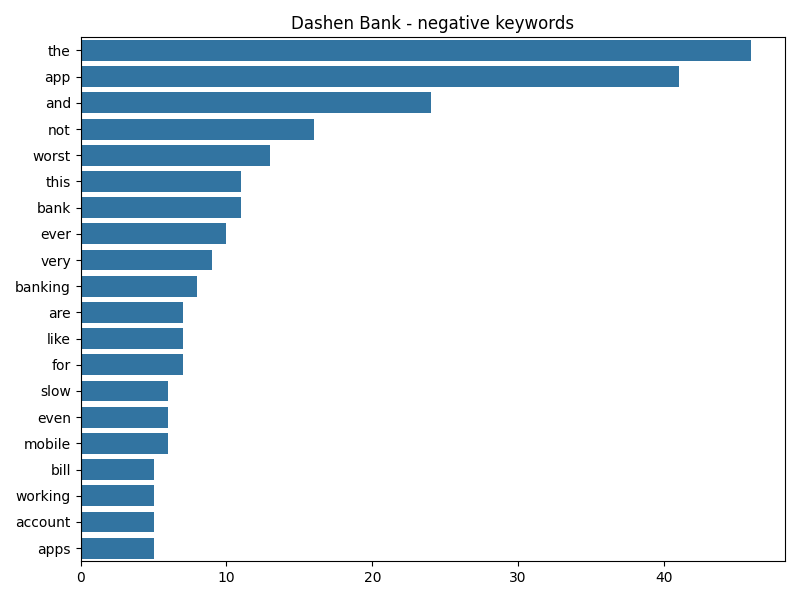

### wordcloud_Dashen Bank_positive.png

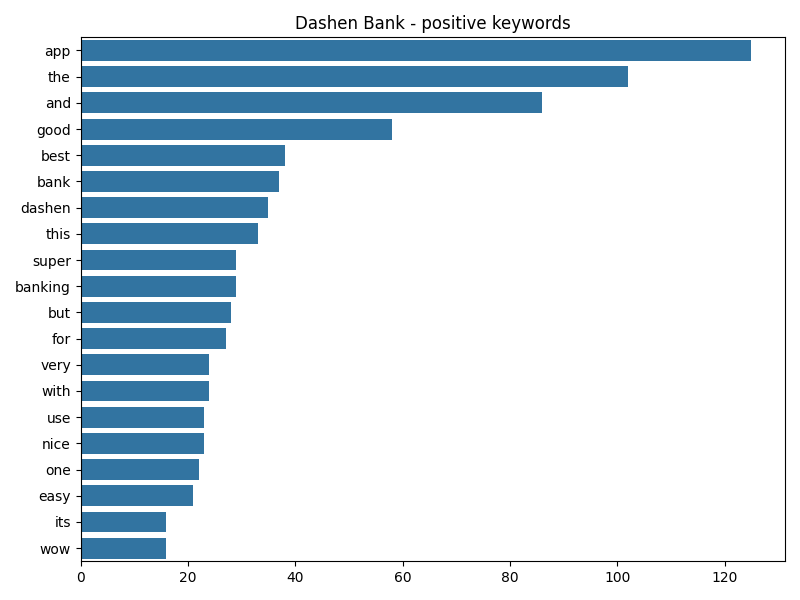

In [7]:
# Display all generated figures from outputs/figures
from pathlib import Path
from IPython.display import display, Image, Markdown

repo_root = Path('..').resolve()
fig_dir = repo_root / 'outputs' / 'figures'

if not fig_dir.exists():
    print('No figures found at', fig_dir)
else:
    imgs = sorted(fig_dir.glob('*.png'))
    if not imgs:
        print('No PNG files found in', fig_dir)
    for p in imgs:
        display(Markdown(f'### {p.name}'))
        display(Image(filename=str(p), width=900))
        print()